# Build and train Linear Regression on tabular data
## Purpose
In this example we will demonstrate how to:

   - Build a Coreset tree for Linear Regression on a dataset.
   - Train a Linear Regression model directly on the Coreset tree using the `fit` method
   - Compare the coreset-based model's quality against a Linear Regression model trained on the full dataset and against a randomly sampled set
   - Add additional samples in batches to the Coreset tree using the `partial_build` method, to simulate a production-like use case where more data is accrued over time and added to the model

In this example we'll be using the well-known New York taxi dataset (https://vaex.readthedocs.io/en/latest/datasets.html). The first 10 million samples out of the 146 million samples in the dataset will be used for the Linear Regression analysis task, to shorten the running time of the notebook. The 10 million samples will be split into 8 million instances in the train set and 2 million instances in the test set.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from time import time
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from dataheroes import CoresetTreeServiceLR

## Prepare dataset

Construct a routine for retrieving and preparing the dataset

In [2]:
import vaex
from urllib.request import urlretrieve
from sklearn.model_selection import train_test_split

def load_yellow_taxi_dataset(start_path : str):
    '''
    loads the first 10M samples of the YellowTaxi2015F32S dataset, described at the link below:
        https://vaex.readthedocs.io/en/latest/datasets.html#New-York-taxi-dataset
    Parameters:
      start_path : str - indicates the local folder where dataset files are to be stored
    Return - dataset's features and targets, split into train and test sets
    '''

    # Processed dataset files
    dataset_file_paths = {
        'x_train' : start_path / 'x_train.npy',
        'y_train' : start_path / 'y_train.npy',
        'x_test'  : start_path / 'x_test.npy',
        'y_test'  : start_path / 'y_test.npy',
    }
    
    all_dataset_files = [dataset_file_paths[key] for key in dataset_file_paths]    
    if not all([f.is_file() for f in all_dataset_files]):
        temp_filepath = start_path / 'yellow_taxi_2015_f32s.hdf5'
        # Download the dataset
        urlretrieve('https://vaex.s3.us-east-2.amazonaws.com/taxi/yellow_taxi_2015_f32s.hdf5', temp_filepath.as_posix())
        
        df = vaex.open(temp_filepath)
        # Select the trips with a non-negative "tip_amount"
        df = df[df["tip_amount"]>=0]
        # Drop incomplete samples
        df = df.dropna()
        # Drop the 2 categorical features, to save us the need to perform one-hot encoding
        df = df.drop(['vendor_id','payment_type'])
        # Convert 2 columns of type datetime64[ns] to float64
        df["pickup_datetime"] = df["pickup_datetime"].astype('float64')
        df["dropoff_datetime"] = df["dropoff_datetime"].astype('float64')
        # Only keep the first 10M samples out of the 146 million samples in the dataset to shorten the running time of the notebook
        df = df[:10_000_000,:]

        # Split the pandas DataFrame into features and targets
        x = df.drop(["tip_amount"]).values
        y = df[["tip_amount"]].values

        # Split the features and targets into train and test subsets
        x_train, x_test, y_train, y_test = train_test_split (
            x, 
            y, 
            train_size=0.8,
            random_state=42,
        )

        # Save the features and targets as numpy arrays
        np.save(dataset_file_paths['x_train'], x_train)
        np.save(dataset_file_paths['y_train'], y_train)
        np.save(dataset_file_paths['x_test'], x_test)
        np.save(dataset_file_paths['y_test'], y_test)

        # Delete the temporary file
        temp_filepath.unlink(missing_ok = False)

    x_train = np.load(dataset_file_paths['x_train'])
    y_train = np.load(dataset_file_paths['y_train'])
    x_test  = np.load(dataset_file_paths['x_test'])
    y_test  = np.load(dataset_file_paths['y_test'])
    # Assure the target train and test arrays have one dimension
    if len(y_train.shape) > 1:
        y_train, y_test = y_train.flatten(), y_test.flatten()
    
    return (x_train, x_test, y_train, y_test)

In [3]:
# Prepare the data directory
data_dir = Path("data")
data_dir.mkdir(parents=True, exist_ok=True)

# Retrieve the dataset splits (train and test)
x_train, x_test, y_train, y_test = load_yellow_taxi_dataset(data_dir)

## 1. Build the tree
Run `build` method to build the tree. The dataset instances are added to the Coreset tree iteratively, to simulate a production-like use case where more data is accrued over time and added to the model. In the end, the tree will include 8M samples. At Coreset tree's construction, we split the data instances into chunks in the size of `chunk_size` and create from each one a Coreset. The `coreset_size` argument represents the coreset size of each node in the tree.


In [4]:
# Initialize the Coreset tree
# The tree uses the local file system to store its data.
# After this step you will have a new directory .dataheroes_cache
coreset_creation_start_time = time()
service_obj = CoresetTreeServiceLR(
    optimized_for='training',
    coreset_size=100,
    chunk_size=125_000,
)
coreset_creation_time = time() - coreset_creation_start_time

## 2. Populate the coreset tree
Add samples to the Coreset tree, in an iterative manner. In each step, 500K samples will be added to the tree.
First, construct a number of variables to be used by the Linear Regression task.

In [5]:
# Define size of dataset slice
x_slice_size = 500_000
# Construct dataset slices: they will be used by the root Coreset and the full dataset
x_slices = np.split(x_train,np.cumsum([x_slice_size]*(8_000_000 // x_slice_size - 1)))
y_slices = np.split(y_train,np.cumsum([x_slice_size]*(8_000_000 // x_slice_size - 1)))
# Construct dataset cumulative slices: they will be used by the full dataset
x_cumulative_slices = [x_train[0:limit] for limit in np.cumsum([x_slice_size]*(8_000_000 // x_slice_size))]
y_cumulative_slices = [y_train[0:limit] for limit in np.cumsum([x_slice_size]*(8_000_000 // x_slice_size))]
# Calculate cumulative number of samples analyzed per iteratio
num_samples_per_iteration = [len(a) for a in x_cumulative_slices]

In each step, train a Linear Regression model on the root Coreset of the tree, using the `fit` method, evaluate the score on the test set and store this score, the time needed for building/updating the coreset plus the time for training the Linear Regression model on the root Coreset of the tree, together with any data required in the next analysis steps.

In [6]:
# Initialize a list of scores, build plus fit times and the number of samples in the root Coreset
coreset_scores = []
coreset_times = []
coreset_root_num_samples = []

for i, (x_slice, y_slice) in enumerate(zip(x_slices, y_slices)):
    if i == 0:
        # In the first iteration use tree's build method to build the tree
        coreset_build_start_time = time()
        service_obj.build(x_slice, y_slice)
        coreset_build_time = time() - coreset_build_start_time
    else:
        # In all but the first iteration use tree's partial_build method to add new samples to the tree
        coreset_build_start_time = time()
        service_obj.partial_build(x_slice, y_slice)
        coreset_build_time = time() - coreset_build_start_time

    # Train a Linear Regression model on the root Coreset of the tree
    coreset_fit_start_time = time()
    coreset_model = service_obj.fit()
    coreset_fit_time = time() - coreset_fit_start_time

    # Update the times list
    coreset_times.append(coreset_build_time + coreset_fit_time)

    # Evaluate the Linear Regression model's score, on the test set
    coreset_score = mean_squared_error(y_test, coreset_model.predict(x_test))
    # Update the scores list
    coreset_scores.append(coreset_score)

    # Obtain the root Coreset of the tree and store the number of samples in it
    coreset = service_obj.get_coreset()
    _, coreset_x, _ = coreset['data']
    coreset_root_num_samples.append(len(coreset_x))

## 3. Run the Linear Regression analysis on the full dataset
The Linear Regression will be performed iteratively, on the full dataset. Starting with the very first 500K samples, of the first iteration, in each new step, the next 500K samples of the full dataset will be appended. Also, in each step, a Linear Regression model will be trained on the current iteration's full number of train samples and the same key performance indicators will be stored, as for the Coreset tree analysis above.

In [7]:
# Initialize a list of scores and train times for the full dataset
full_dataset_scores = []
full_dataset_times = []

for _, (x_cumulative_slice, y_cumulative_slice) in enumerate(zip(x_cumulative_slices, y_cumulative_slices)):
    # Fit a Linear Regression model on the cumulative slice of the full dataset
    full_dataset_fit_start_time = time()
    full_dataset_model = LinearRegression().fit(x_cumulative_slice, y_cumulative_slice)
    full_dataset_fit_time = time() - full_dataset_fit_start_time

    # Update the times list
    full_dataset_times.append(full_dataset_fit_time)
    
    # Evaluate the Linear Regression model on the test set
    full_dataset_score = mean_squared_error(y_test, full_dataset_model.predict(x_test))
    # Update the scores list
    full_dataset_scores.append(full_dataset_score)

## 4. Run the Linear Regression analysis on a randomly sampled set
Specify how large the randomly sampled set should be as a proportion of the train set. The random set is updated and evaluated iteratively by accruing, in each iteration, the specified percentage of randomly sampled instances from the current train slice.

In [8]:
random_set_size_percentage = 0.15

Train a Linear Regression model on the random set, in each iteration, storing the same key performance indicators as for the Coreset tree

In [30]:
# Initialize a list of scores and train times for the randomly sampled set
random_set_scores = []
random_set_times = []
# Define arrays for the features and the targets of the random set; updated in each iteration
x_random_set = np.empty((0, x_train.shape[1]))
y_random_set = np.empty((0,))

for i, (x_slice, y_slice) in enumerate(zip(x_slices, y_slices)):
    # Accrue random samples from the current slice into the random set
    random_indices = np.random.randint(len(x_slice), size=int(len(x_slice) * random_set_size_percentage))
    x_random_set = np.vstack((x_random_set, x_slice[random_indices, :]))
    y_random_set = np.append(y_random_set, y_slice[random_indices])

    # Fit a Linear Regression model on the cumulative slice of the full dataset
    random_sub_dataset_fit_start_time = time()
    random_sub_dataset_model = LinearRegression().fit(x_random_set, y_random_set)
    random_sub_dataset_fit_time = time() - random_sub_dataset_fit_start_time

    # Update the times list
    random_set_times.append(random_sub_dataset_fit_time)
    
    # Evaluate the scores list
    random_sub_dataset_score = mean_squared_error(y_test, random_sub_dataset_model.predict(x_test))
    # Update the score for the Linear Regression fitted on the full dataset
    random_set_scores.append(random_sub_dataset_score)

## 5 Visualize key performance indicators

### 5.1 Visualize coreset tree, full dataset and random set Linear Regression scores
Plot the costs of the three Linear Regression models, for each iteration.

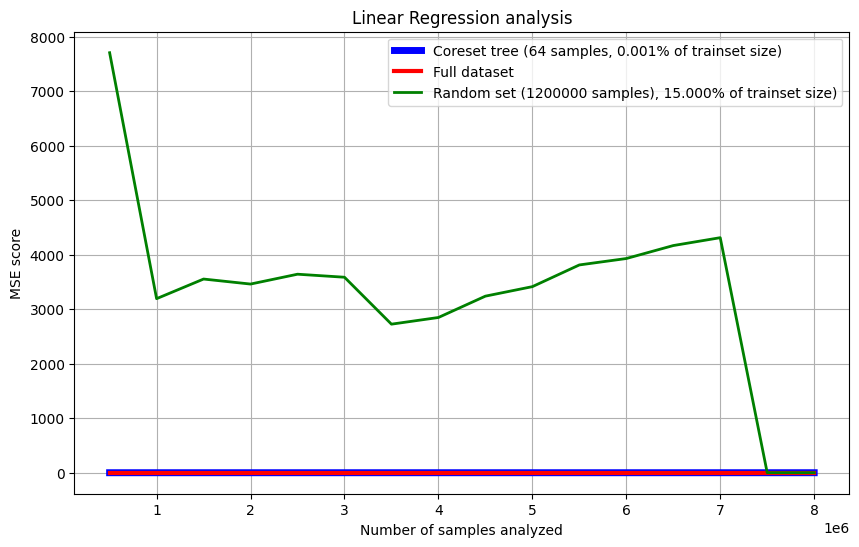

In [31]:
fig_scores, axd_scores = plt.subplots(figsize=(10, 6))
axd_scores.plot(num_samples_per_iteration, coreset_scores, linewidth=5, label=f"Coreset tree ({max(coreset_root_num_samples)} samples, {(max(coreset_root_num_samples) * 100 / x_train.shape[0]):.3f}% of trainset size)", color="blue")
axd_scores.plot(num_samples_per_iteration, full_dataset_scores, linewidth=3, label=f"Full dataset ", color="red")
axd_scores.plot(num_samples_per_iteration, random_set_scores, linewidth=2, label=f"Random set ({len(x_random_set)} samples), {(len(x_random_set) * 100 / x_train.shape[0]):.3f}% of trainset size)", color="green")
axd_scores.grid(True)
axd_scores.ticklabel_format(useOffset=False)
axd_scores.set_ylabel('MSE score')
axd_scores.set_xlabel("Number of samples analyzed")
axd_scores.legend()
_ = axd_scores.set_title('Linear Regression analysis')

### 5.2 Visualize the timing for training the Linear Regression model on the Coreset tree, on the full dataset and on the random set
Plot the train time for the full dataset's and the random set's Linear Regression models. Plot the build+train time for the Linear Regression model trained on the Coreset.

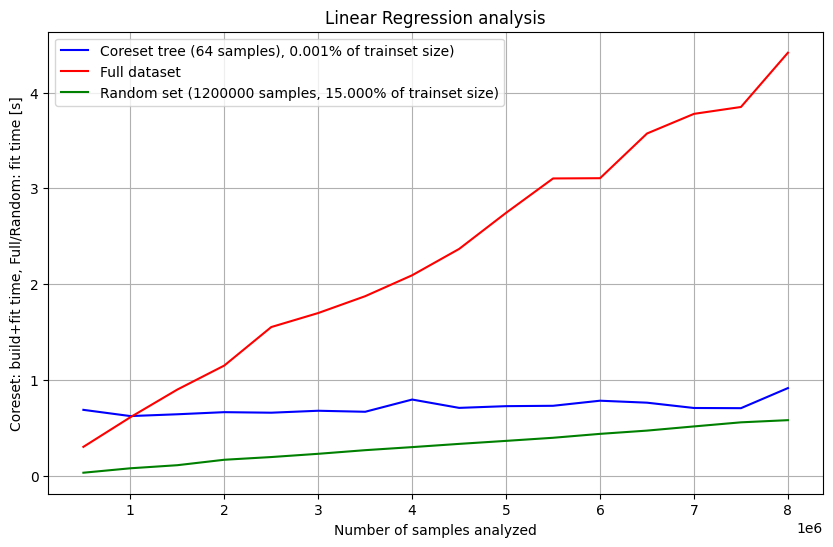

In [33]:
fig_scores, axd_scores = plt.subplots(figsize=(10, 6))
axd_scores.plot(num_samples_per_iteration, coreset_times, label=f"Coreset tree ({max(coreset_root_num_samples)} samples), {(max(coreset_root_num_samples) * 100 / x_train.shape[0]):.3f}% of trainset size)", color="blue")
axd_scores.plot(num_samples_per_iteration, full_dataset_times, label=f"Full dataset ", color="red")
axd_scores.plot(num_samples_per_iteration, random_set_times, label=f"Random set ({len(x_random_set)} samples, {(len(x_random_set) * 100 / x_train.shape[0]):.3f}% of trainset size)", color="green")
axd_scores.grid(True)
axd_scores.ticklabel_format(useOffset=False)
axd_scores.set_ylabel('Coreset: build+fit time, Full/Random: fit time [s]')
axd_scores.set_xlabel("Number of samples analyzed")
axd_scores.legend()
_ = axd_scores.set_title('Linear Regression analysis')